# 08.02 - Analysis of Results on Held Out Test Data

## Imports & setup

In [1]:
import pathlib
import warnings
from datetime import datetime
import sys
import pickle
import joblib
import gc

import pandas as pd
import numpy as np

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import palettable
import seaborn as sns

# Imports
sys.path.append("..")
from src.utils.utils import (AnnualTimeSeriesSplit,
                             RollingAnnualTimeSeriesSplit,
                             bound_precision,
                             run_cross_val,
                             save_run_results,
                             run_data_split_cross_val)
from src.features.features import CyclicalToCycle
from src.models.models import SK_SARIMAX, SK_Prophet, SK_Prophet_1
from xgboost.sklearn import XGBRegressor
from src.visualization.visualize import (plot_prediction,
                                         plot_joint_plot,
                                         residual_plots,
                                         resids_vs_preds_plot,
                                         print_residual_stats)
#b # Packages
from sklearn.pipeline import Pipeline
# from skoot.feature_selection import FeatureFilter
from skoot.preprocessing import SelectiveRobustScaler
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import pmdarima as pm



inline_rc = dict(mpl.rcParams)


# Display
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
figsize=(15,7)
warnings.filterwarnings(action='ignore')
%matplotlib inline

# Data
PROJECT_DIR = pathlib.Path.cwd().parent.resolve()
CLEAN_DATA_DIR = PROJECT_DIR / 'data' / '05-clean'
MODELS_DIR = PROJECT_DIR / 'data' / 'models'
RESULTS_PATH = PROJECT_DIR / 'data' /'results' / 'results.csv'

/home/david/anaconda3/envs/ana_py37tf/lib/python3.7/site-packages/ipykernel/__main__.py:52: MatplotlibDeprecationWarning:


The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.



## Ensemble Modeling Strategy

![ensemble flow map](images/ensemble-flow-map.PNG)

The code below refers to LH and RH as the Left Hand and Right Hand side of this image.

It also incorporates a custom time series cross validation scheme, which makes it look more complex.

In [2]:
df = pd.read_csv(CLEAN_DATA_DIR / 'clean-features.csv', parse_dates=True, index_col=0)

In [3]:
X = df.copy(deep=True)
X = X.loc['2004': '2018']
y = X.pop('daily_peak')
X.head()

,hmdxx_min,hmdxx_max,hmdxx_median-1,hmdxx_max_hour,temp_min,temp_max,dew_point_temp_max,sun_rise,sun_set,visibility_mean,day_of_week,week_of_year,day_type
2004-05-17,7.735889,20.970716,12.375721,17.0,7.8,18.5,13.3,6.0,21.0,19.700000,0.0,21.0,0
2004-05-18,11.932519,26.743660,16.712871,14.0,11.4,22.2,17.4,6.0,21.0,17.429167,1.0,21.0,0
2004-05-19,9.227487,18.550839,23.478914,13.0,8.9,18.5,9.5,6.0,21.0,20.366667,2.0,21.0,0
2004-05-20,9.012192,31.353519,13.901348,17.0,10.3,23.8,20.1,6.0,21.0,15.350000,3.0,21.0,0
2004-05-21,14.808592,24.557386,20.764855,0.0,13.2,19.2,17.1,6.0,21.0,20.966667,4.0,21.0,1


In [4]:
y.tail()

2018-10-01    16531.0
2018-10-02    16772.0
2018-10-03    16212.0
2018-10-04    16061.0
2018-10-05    16269.0
Name: daily_peak, dtype: float64

## Averaging Model

In [5]:
N_SPLITS = 10
from sklearn.svm import SVR

def run_model(X,y):
    
    scores_dicts = {'train':
                        {'mae': [],
                         'bound': []},
                    'test':
                        {'mae': [],
                         'bound': []}}
    
    # Pre-processing
    # Robust Scaling
    robust_scaler_cols = ['hmdxx_min', 'hmdxx_max', 'hmdxx_median-1', 'temp_min','temp_max',
                          'dew_point_temp_max', 'visibility_mean']
    # Cyclical Transform
    rscaler = SelectiveRobustScaler(cols=robust_scaler_cols, trans_col_name=robust_scaler_cols)
    cyclical0 = CyclicalToCycle(cycle_name='hmdxx_max_hour', periods_per_cycle=24)
    cyclical1 = CyclicalToCycle(cycle_name='sun_rise', periods_per_cycle=24)
    cyclical2 = CyclicalToCycle(cycle_name='sun_set', periods_per_cycle=24)
    cyclical3 = CyclicalToCycle(cycle_name='day_of_week', periods_per_cycle=24)
    cyclical4 = CyclicalToCycle(cycle_name='week_of_year', periods_per_cycle=24)
    
    # Prophet
    factor = 0.05
    seas_factor = 0.05
    mode = 'multiplicative'
    regressors = {'hmdxx_min': (factor, False, mode),
                  'hmdxx_max': (factor, False, mode),
                  'hmdxx_median-1': (factor, False, mode),
                  'sin_hmdxx_max_hour': (seas_factor, False, mode),
                  'cos_hmdxx_max_hour': (seas_factor, False, mode),
                  'temp_min': (factor, False, mode),
                  'temp_max': (factor, 'auto', mode),
                  'dew_point_temp_max': (factor, False, mode),
                  'sin_sun_rise': (factor, False, mode),
                  'cos_sun_rise': (factor, False, mode),
                  'sin_sun_set': (factor, False, mode),
                  'cos_sun_set': (factor, False, mode),
                  'sin_day_of_week': (factor, False, mode),
                  'cos_day_of_week': (factor, False, mode),
                  'sin_week_of_year': (factor, False, mode),
                  'cos_week_of_year': (factor, False, mode),
                  'visibility_mean': (factor, False, mode),
                  'day_type': (factor, False, mode)}

    prophet_model = SK_Prophet_1(regressors=regressors,
                           pred_periods=96)

        
    # SARIMAX
    sarimax_model = SK_SARIMAX(order=(1,0,1), seasonal_order=(1,0,0,96), trend='c')
    
    # XGBoost
    xgboost_left = SVR(kernel='poly', C=100, gamma='auto', degree=5, epsilon=.1, coef0=1)
    xgboost_right = SVR(kernel='poly', C=100, gamma='auto', degree=5, epsilon=.1, coef0=1)
#     resid_model =  KNeighborsRegressor(n_neighbors=10, weights='distance')


    atscv = RollingAnnualTimeSeriesSplit(n_splits=N_SPLITS, goback_years=5)

    for train_indces, test_indces in atscv.split(X, y):
        X_train = X.iloc[train_indces]; y_train = y.iloc[train_indces]
        X_test = X.iloc[test_indces] ; y_test = y.iloc[test_indces]

        # Pre-processing Cyclic features
        cyclical0.fit(X_train, y_train)
        X_t_train = cyclical0.transform(X_train)
        X_t_test = cyclical0.transform(X_test)
        
        cyclical1.fit(X_t_train, y_train)
        X_t_train = cyclical1.transform(X_t_train)
        X_t_test = cyclical1.transform(X_t_test)
        
        cyclical2.fit(X_t_train, y_train)
        X_t_train = cyclical2.transform(X_t_train)
        X_t_test = cyclical2.transform(X_t_test)

        cyclical3.fit(X_t_train, y_train)
        X_t_train = cyclical3.transform(X_t_train)
        X_t_test = cyclical3.transform(X_t_test)
        
        cyclical4.fit(X_t_train, y_train)
        X_t_train = cyclical4.transform(X_t_train)
        X_t_test = cyclical4.transform(X_t_test)
        
        # Pre-processing Robust Scaler
        rscaler.fit(X_t_train, y_train)
        X_t_train = rscaler.transform(X_t_train)
        X_t_test = rscaler.transform(X_t_test)

        # LH Initial y Prediction
        sarimax_model.fit(X_t_train, y_train)
        y_hat_train = sarimax_model.predict(X_t_train)
        y_hat_test = sarimax_model.predict(X_t_test)

        # LH Get Residuals
        r_train = y_train - y_hat_train
        r_test = y_test - y_hat_test

        # LH Fit & Predict Residuals
        xgboost_left.fit(X_t_train, r_train)
        r_hat_train = xgboost_left.predict(X_t_train)
        r_hat_test = xgboost_left.predict(X_t_test)

        # LH Adder - Add Residual Prediction to Initial y Prediction
        y_hat_plus_train = y_hat_train + r_hat_train
        y_hat_plus_test = y_hat_test + r_hat_test

        mae_train = mean_absolute_error(y_train, y_hat_plus_train)
        mae_test = mean_absolute_error(y_test, y_hat_plus_test)

        # RH Initial y Prediction
        prophet_model.fit(X_t_train, y_train)
        y_hat2_train = prophet_model.predict(X_t_train)
        y_hat2_test = prophet_model.predict(X_t_test)

        # RH Get residuals
        r2_train = y_train - y_hat2_train
        r2_test = y_test - y_hat2_test

        # RH Fit & Predict Residuals
        xgboost_right.fit(X_t_train, r2_train)
        r_hat2_train = xgboost_right.predict(X_t_train)
        r_hat2_test = xgboost_right.predict(X_t_test)

        # RH Adder - Add Residual prediction to Initial y Prediction
        y_hat_plus2_train = y_hat2_train + r_hat2_train
        y_hat_plus2_test = y_hat2_test + r_hat2_test

        # Average the Predictions
        y_final_train = pd.concat([y_hat_plus_train, y_hat_plus2_train], axis=1).mean(axis=1)
        y_final_test = pd.concat([y_hat_plus_test, y_hat_plus2_test], axis=1).mean(axis=1)
        
        
        mae_train = mean_absolute_error(y_train, y_final_train)
        mae_test = mean_absolute_error(y_test, y_final_test)
        bound_prec_train = bound_precision(y_train, y_final_train)
        bound_prec_test = bound_precision(y_test, y_final_test)
        
        scores_dicts['train']['mae'].append(mae_train)
        scores_dicts['train']['bound'].append(bound_prec_train)
        scores_dicts['test']['mae'].append(mae_test)
        scores_dicts['test']['bound'].append(bound_prec_test)    
        
    # Use the time series pred vals DataFrame as a template
    pred_vals = prophet_model.get_pred_values()
    for col in pred_vals.columns:
        if col != 'is_forecast':
            pred_vals[col] = np.NaN
    # Fill in the values for y
    pred_vals.loc[y_train.index, 'y'] = y_train.values
    pred_vals.loc[y_test.index, 'y'] = y_test.values
    # Replace the Time Series Models predictions with the
    # combined prediction values
    pred_vals.loc[y_hat_plus_train.index, 'yhat'] = y_final_train.values
    pred_vals.loc[y_hat_plus_test.index, 'yhat'] = y_final_test.values
    # Calculate the residuals
    pred_vals['resid'] = pred_vals['y'].subtract(pred_vals['yhat'])
    # Elimatate the obsolete columns such as confidence intervals
    pred_vals = pred_vals[['y', 'yhat', 'resid', 'is_forecast']]

    return pred_vals, scores_dicts

In [6]:
pred_vals, d = run_model(X, y)
print(d)
print('Train')
print(np.mean(d['train']['mae']))
print(np.mean(d['train']['bound']))
print('Test')
print(np.mean(d['test']['mae']))
print(np.mean(d['test']['bound']))

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
{'train': {'mae': [332.90157008828027, 397.4863467263492, 439.63666604738563, 454.67442331389464, 416.0266520990629, 359.3174229745842, 353.08945990824157, 321.19585357913024, 340.18981214450577, 338.62898282343355], 'bound': [0.6, 0.4, 0.6, 1.0, 0.8, 0.6, 0.6, 0.6, 0.6, 0.6]}, 'test': {'mae': [1496.6370552866247, 678.6279796455698, 1006.8610104244163, 483.49514992727444, 630.4804043110831, 437.4141092230388, 416.39166621747336, 493.66045233308586, 906.7154422810064, 887.5870180422495], 'bound': [0.8, 0.6, 0.8, 1.0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.6]}}
Train
375.31471897048675
0.6399999999999999
Test
743.7870287691823
0.78


In [7]:
pred_vals

,y,yhat,resid,is_forecast
2013-05-21,18234.0,18233.999787,0.000213,0
2013-05-22,18002.0,18001.998251,0.001749,0
2013-05-23,17027.0,17026.900251,0.099749,0
2013-05-24,15890.0,15890.000585,-0.000585,0
2013-05-27,16288.0,16326.696791,-38.696791,0
...,...,...,...,...
2018-10-01,16531.0,17502.097909,-971.097909,1
2018-10-02,16772.0,22374.014575,-5602.014575,1
2018-10-03,16212.0,15627.144247,584.855753,1
2018-10-04,16061.0,15908.817634,152.182366,1


### Review the last model run in the Cross Validation

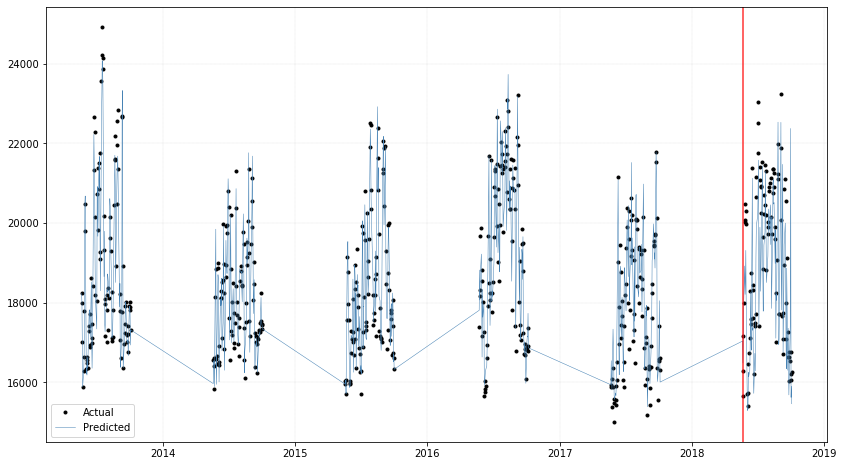

In [8]:
ig, ax = plot_prediction(pred_vals, goback_years=20)
plt.show();

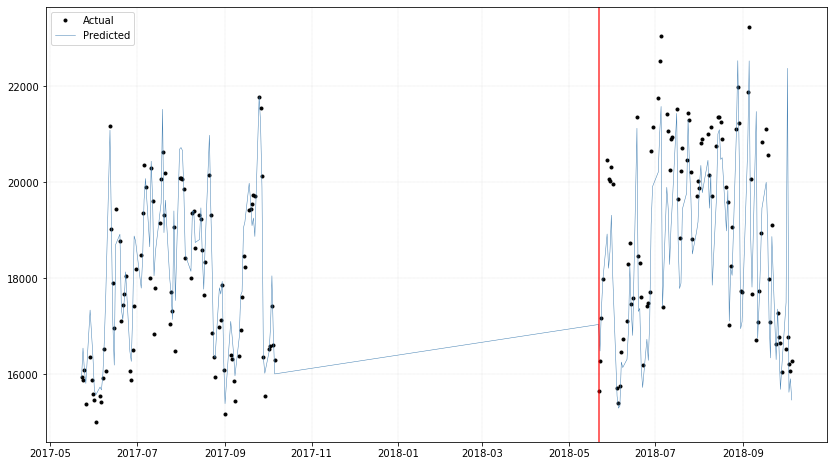

In [9]:
fig, ax = plot_prediction(pred_vals, goback_years=2)
plt.show();

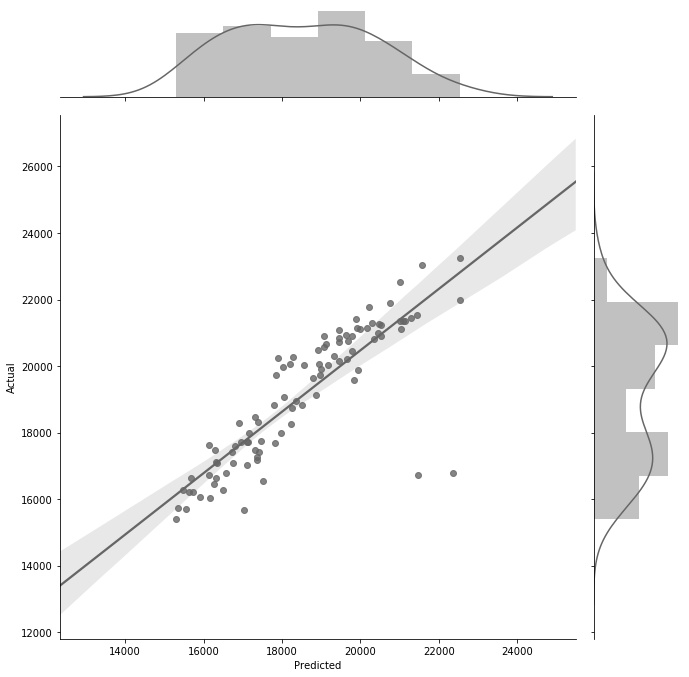

In [10]:
fig, ax = plot_joint_plot(pred_vals, goback_years=1)
plt.show();

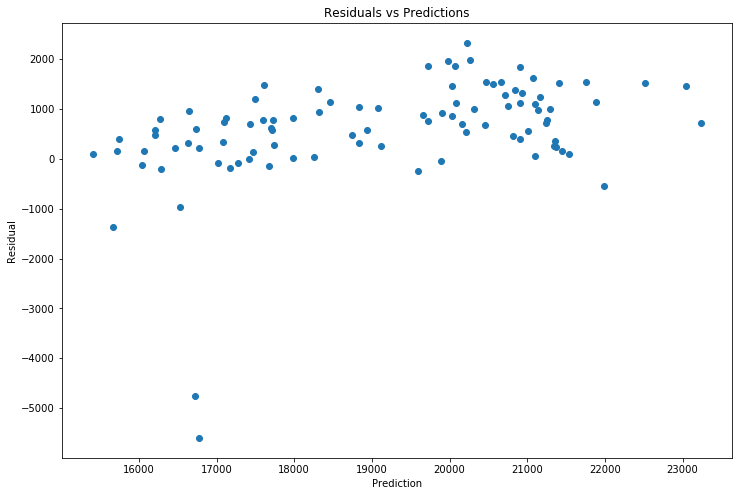

In [11]:
fig, ax = resids_vs_preds_plot(pred_vals)
plt.show()

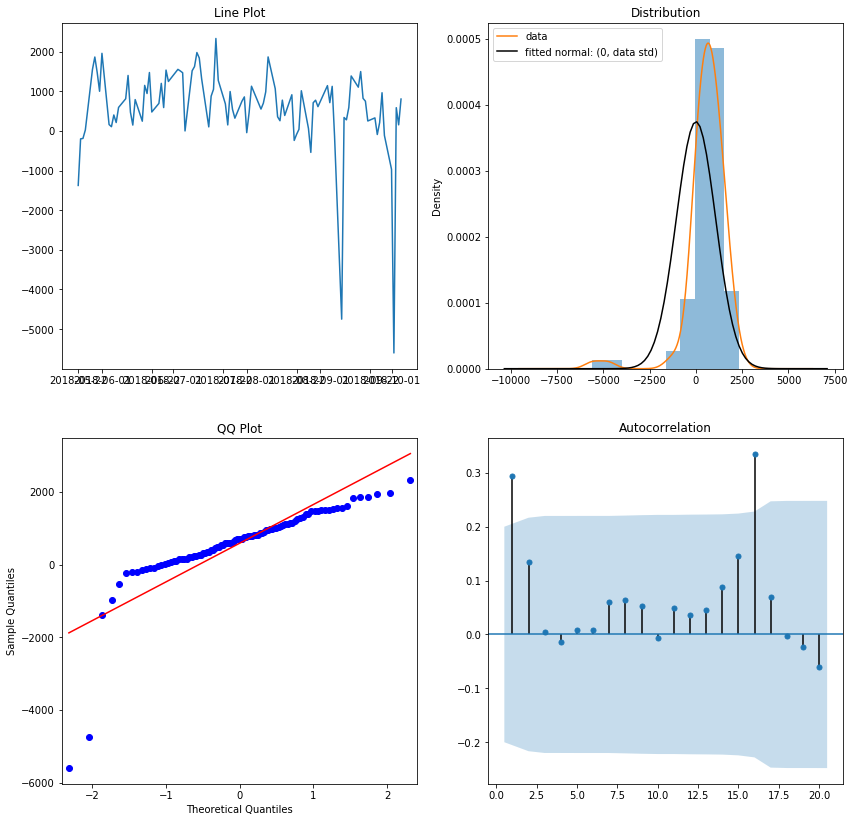

In [12]:
fig, ax = residual_plots(pred_vals)
plt.show()

In [13]:
print_residual_stats(pred_vals)

LJung Box Corr p value:		0.31492
Jarque Bera Normal p value:	0.0


In [14]:
ser = pd.Series(d['test']['bound'], index=range(2009, 2019)).rename('Test Data')


In [15]:
ser

2009    0.8
2010    0.6
2011    0.8
2012    1.0
2013    0.8
2014    0.8
2015    0.8
2016    0.8
2017    0.8
2018    0.6
Name: Test Data, dtype: float64

In [16]:
ser.to_csv(PROJECT_DIR / 'data' /'results' / 'test_results.csv')

In [17]:
res = pd.read_csv(PROJECT_DIR / 'data' /'results' / 'test_results.csv', index_col=0, header=None, squeeze=True)
res.rename('Test Data', inplace=True)
res

0
2009    0.8
2010    0.6
2011    0.8
2012    1.0
2013    0.8
2014    0.8
2015    0.8
2016    0.8
2017    0.8
2018    0.6
Name: Test Data, dtype: float64